### Manmeet Singh 013906919

Assignment 2 Part I: Write autodiff python library and based on it, do  mnist classifier (similar to last exercise but using autodiff library  that you will write instead of direct numpy)

In [0]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

%matplotlib inline
np.random.seed(0)

In [0]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [27]:
X_train.shape

(60000, 28, 28)

In [0]:
class Tensor():

    def __init__(self, data, requires_grad=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        # whether to run backpropagation or not
        self.requires_grad = requires_grad
        # tensor gradient
        self._grad = None
        # operation if this tensor was used in it
        self._grad_fn = None

    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.requires_grad:
            raise Exception('This tensor is not backpropagated')
        return self._grad_fn

    @property
    def grad(self):
        return self._grad

    def backward(self, grad=None):
        if not self.grad_fn:
            return False

        if grad is None and self._grad is None:
            # in case if this is last loss tensor
            grad = self.__class__(1., requires_grad=False)

        elif self.grad is not None:
            grad = self._grad

        if not self.requires_grad:
            raise Exception('This tensor is not backpropagated')

        self.grad_fn.backward(grad)
        return True

    def __str__(self):
        return f'Tensor({str(self.data)})'

    def add_grad(self, grad):
        if self._grad is None:
            self._grad = grad
        else:
            self._grad += grad

    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

class Op():

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._grad_fn = self
        return self.out


In [0]:
class AddOp(Op):

    '''Sumation operation with 2 tensors'''

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        # created tensor should be backpropagated if at least one 
        # of the input is backpropagated
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data + y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            # as we have matrix operation one of the parameters can have partial shape
            # in such scenarion we need to sum gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()

In [0]:
class MulOp(Op):

    '''Multiplication operation with 2 tensors'''

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data * y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            self.x.add_grad(Tensor(grad.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            self.y.add_grad(Tensor(grad.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()

In [0]:
class Layer():

    def forward(self):
        raise NotImplemented
    
    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid():

    def forward(self,x):
        self.x = x   
        return 1/(1+np.exp(-x))
      
    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

class Relu(Layer):

    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)
      
    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss
      
    def backward(self, grad=None):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

class MSE(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr
    
    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using 
        # gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)
        
        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input

In [0]:
class Model(Layer):

    def __init__(self, lr=0.0001):
        self.lr = lr
        self.layers = [
            Linear(3,15, lr=self.lr),
            Relu(),
            Linear(15,1, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad

mm = Model()

def yf(x1,x2,x3):
    return np.array([2 * x1 + 3*x2 + 4*x3 + 5],dtype=np.float32)

loss = MSE()

for i in range(20000):
    x1 = np.random.random()*30
    x2 = np.random.random()*20
    x3 = np.random.random()*11
    y = mm(np.array([[x1,x2,x3]]))
    err = loss(y, yf(x1,x2,x3))
    
    yb = loss.backward()
    yb = mm.backward(yb)
    if i % 100 == 0:
        print(err)
        print('VAL Target:',yf(1,2,3), 'Res:',mm(np.array([[1,2,3]])), 'Loss:',loss(yf(1,2,3), mm(np.array([[1,2,3]]))))
        print('---------')

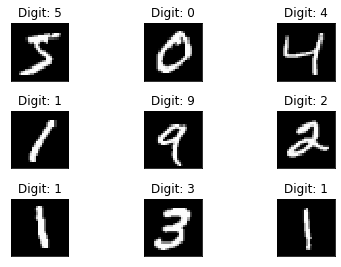

In [37]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

Text(0.5, 1.0, 'Pixel Value Distribution')

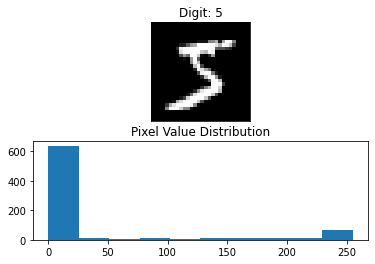

In [38]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")

In [39]:
# Shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# build the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize the data
X_train /= 255
X_test /= 255

# print the final input shape
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [0]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

class Model(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad


simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 
for e in range(7):
    for i, (img, label) in enumerate(ld):
        x = img.view(2,-1).numpy()

        res = mm(x)
        _loss = loss(res, label.numpy())
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')
            
